[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - Training Spiking Neural Networks with snnTorch
## Tutorial 5
### 강의 [Jason K. Eshraghian](https://www.ncg.ucsc.edu)
### 번역 [ToToKr](https://github.com/moerai)
<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 튜토리얼 시리즈는 다음 문서를 기반으로 합니다. 이러한 리소스나 코드가 작업에 유용하다고 생각되면 다음 소스를 인용해 주세요:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>



# Introduction
이번 튜토리얼에서 당신은:
* recurrent 네트워크로 스파이크 뉴런이 어떻게 구현되는지 배웁니다.
* 시간 경과에 따른 역전파와 스파이크의 미분불능(non-differentiability)과 같은 SNN의 문제를 이해할 수 있습니다.
* 정적 MNIST 데이터 세트에서 fully-connected network를 훈련합니다.

<!-- * Implement various backprop strategies:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

>이 튜토리얼의 일부는 Friedemann Zenke의 SNN에 대한 광범위한 작업에서 영감을 받앗습니다. [여기](https://github.com/fzenke/spytorch)에서 surrogate gradients에 대한 그의 repo를 확인 할 수 있습니다. 그리고 추천하는 논문은 다음과 같습니다: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks.](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51–63.

튜토리얼의 마지막에는 기본적인 지도 학습 알고리즘을 구현합니다. 원본 Static MNIST 데이터 세트를 사용하고 gradient descent를 사용하여 이미지 분류를 수행하는 multi-layer fully-connected SNN을 훈련합니다.

Google Colab 실행을 하는 경우:
* 다음 메뉴에서 `런타임` > `런타임 유형 변경` > `하드웨어 가속기: GPU`를 확인하여 GPU를 연결합니다.
* 다음 셀을 클릭하고 `Shift+Enter`를 눌러 최신 PyPi 배포판의 snnTorch를 설치합니다.

In [ ]:
!pip install snntorch

In [5]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. A Recurrent Representation of SNNs

튜토리얼3에서 leaky integrate-and-fire (LIF) 뉴런의 재귀적인 표현(recursive)을 도출했습니다:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$

여기서 input 시냅스 전류는 $I_{\rm in}[t] = WX[t]$ 로 해석되며, $X[t]$ 는 임의의 스파이크 input, 시간 or Step에 가변적인 전압, 또는 가중치가 없는 시간 or Step에 가변적인 전류일 수 있습니다. 스파이크는 다음 방정식으로 표현되며, 멤브레인 전위가 임계값을 초과하면 스파이크가 방출됩니다:

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

이산적, 재귀적 형태의 스파이크 뉴런 공식은 Recurrent Neural Networks (RNNs)과 시퀀스 기반 모델 훈련의 발전을 거의 완벽하게 활용 할 수 있습니다. 이는 막전위의 붕괴에 대한 *암시적(implicit)* recurrent 연결을 사용하여 설명 할 수 있으며, 출력 스파이크 $S_{\rm out}$가 입력으로 피드백되는 *명시적(explicit)* recurrent와 구분됩니다. 아래 그림에서 $-U_{\rm thr}$로 가중치를 설정하는 연결은 리셋 메커니즘 $R[t]$를 나타냅니다.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

그림의 오른쪽 그래프는 계산이 어떻게 수행되는지 명시적으로 설명해줍니다. 오른쪽으로 나아가는 과정은 출력과 손실을 계산하기 위해 시간을 앞으로, 기울기를 계산하기 위해 시간을 뒤로 이동하는 흐름을 보여줍니다. 시뮬레이션하는 시간 단계가 많을수록 그래프는 deep해집니다.

기존 RNNs는 $\beta$를 학습 가능한 파라미터로 취급합니다. 이는 SNN에서도 가능하지만, 기본적으로 하이퍼파라미터로 취급합니다. 왜냐하면 vanishing or exploding 그레디언트 문제를 하이퍼파라미터 검색으로 대체할 수 있기 때문입니다. 향후 튜토리얼에서 $\beta$를 학습 가능한 파라미터로 만드는 방법도 설명할 예정입니다.

# 2. The Non-Differentiability of Spikes
## 2.1 Training Using the Backprop Algorithm

$(2)$에서 $S$ 와 $U$의 관계를 표현 할 수 있는 대안은 다음과 같습니다:

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$

여기에서 $\Theta(\cdot)$는 Heaviside step 함수입니다:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

이러한 형태의 네트워크를 훈련하는 데는 몇 가지 심각한 문제가 있습니다. 아래 *forward pass*에 표시된 것처럼 이전 *"Recurrent representation of spiking neurons"* 그림(수식$ (2) $ 아래 있음)의 계산 그래프의 단일 시간 단계를 생각해 보겠습니다:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

목표는 가중치에 대한 loss의 gradient를 사용하여 네트워크를 훈련시켜 손실을 최소화 하도록 가중치를 업데이트 하는 것입니다 역전파 알고리즘은 Chain rule을 이용하여 이를 달성합니다:

$$\frac{\partial \mathcal{L}}{\partial W} =
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$

수식 $(1)$에서 $\partial I/\partial W=X$와 $\partial U/\partial I=1$를 구할 수 있습니다. 아직 loss 함수를 정의하지 않았지만,  $\partial \mathcal{L}/\partial S$에는 cross-entropy 또는 MSE(Mean-Square Error) loss와 유사한 형태의 분석적 해가 있다고 가정할 수 있습니다(이에 대해서는 곧 자세히 설명하겠습니다).

하지만, 우리가 다루고자 하는 항은 $\partial S/\partial U$ 입니다. 수식 $(3)$에서 Heaviside step 함수의 미분은 Dirac Delta 함수이며, 임계값 $U_{\rm thr} = \theta$를 제외하고는 모든 곳에서 0으로 평가됩니다. 즉, 기울기(gradient)는 거의 항상 0이 되고(또는 $U$가 임계값에 정확히 위치하는 포화 상태가 되어) 학습이 이루어지지 않습니다. 이를 **dead neuron problem**이라고 부릅니다.

## 2.2 Overcoming the Dead Neuron Problem

dead neuron problem를 해결하는 가장 일반적인 방법은 포워드 패스 동안 Heaviside 함수를 그대로 유지하되, 백워드 패스 동안 학습 과정을 죽이지 않는 것으로 미분 함수를 $\partial S/\partial U$에서 $\partial \tilde{S}/\partial U$로 바꾸어 표기하는 것입니다($ S $ 에 틸다[~]가 추가됨). 이상하게 들릴 수 있지만, 신경망은 이러한 근사치에 상당히 강건(Robust)하다는 것이 밝혀졌습니다. 이를 일반적으로 *surrogate gradient*접근법 이라고 부릅니다.


surrogate gradients를 사용하는 데는 다양한 옵션이 존재하며, [Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 이러한 방법에 대해 자세히 알아보겠습니다. snnTorch (as of v0.6.0)의 기본 방법은 아크탄젠트 함수로 Heaviside 함수를 smooth하게 하는 것입니다. 사용되는 역방향 도함수는 다음과 같습니다:

$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$

여기서 왼쪽 화살표는 대체를 나타냅니다.

수식 $(1)-(2)$에서 설명한 것과 동일한 뉴런 모델 (a.k.a., 튜토리얼3의 `snn.Leaky` 뉴런 모델)이 아래 PyTorch에서 구현되어 있습니다. 이해가 되지 않더라도 걱정하지 마세요. 잠시 후 snnTorch를 이용해서 한 줄의 코드로 압축하겠습니다:

In [2]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

surrogate gradient는 $\partial S/\partial U$에만 적용되고 $\partial R/\partial U$에는 적용되지 않으므로 리셋 메커니즘은 계산 그래프에서 분리되어 있습니다.

위의 뉴런은 다음을 사용하여 인스턴스화됩니다:

In [3]:
lif1 = LeakySurrogate(beta=0.9)

이 뉴런은 이전 튜토리얼처럼 for-loop를 사용하여 시뮬레이션 할 수 있으며, PyTorch의 automatic differentation(autodiff) 메커니즘은 백그라운드에서 gradient를 추적합니다.

또는, `snn.Leaky` 뉴런을 호출하여 동일한 작업을 수행할 수 있습니다.
실제로 snnTorch에서 뉴런 모델을 호출할 때마다 기본적으로 *ATan* surrogate gradient가 적용됩니다:

In [4]:
lif1 = snn.Leaky(beta=0.9)

이 뉴런의 작동방식을 찾아보려면 [튜토리얼3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)을 확인하세요.

# 3. Backprop Through Time
방정식 $(4)$는 단일 time step (아래 그림에서 *immediate influence*라고 함)에 대한 기울기만 계산하지만, 시간을 통한 역전파(BPTT) 알고리즘은 *모든* 하위 단계까지의 기울기를 계산하여 합산합니다.

가중치 $W$는 모든 time step에 적용되므로 loss도 모든 time step에서 계산된다고 가정합니다, 가중치가 현재 및 과거 손실에 미치는 영향을 합산하여 글로벌 그래디언트를 정의해야 합니다:

$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} =
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$

$(5)$의 요점은 causality를 보장하는 것입니다: $s\leq t$를 제한함으로써, 손실(loss)에 대한 $W$의 즉각적이고 이전 영향의 기여도만 고려합니다. 순환 시스템은 모든 step에 걸쳐 가중치를 공유하도록 제한합니다: $W[0]=W[1] =~... ~ = W$. 따라서, $W[s]$의 변화는 모든 $W$에 동일한 영향을 미치며, 이는 $\partial W[s]/\partial W=1$을 의미합니다:

$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$

예를들어, $s = t-1$ *단독*으로 끼친 이전 영향을 분리하면, 역방향 패스는 시간을 한 단계(step)씩 거슬러 올라가야 합니다; loss에 대한 $W[t-1]$의 영향은 다음과 같이 쓸 수 있습니다:

$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} =
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{Eq.~(5)}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$

우리는 이미 $(4)$에서 $\partial U[t]/\partial U[t-1]$를 제외한 모든 항을 다루었습니다. $(1)$에서, 이 시간에 대한(temporal) 도함수(derivative)는 단순히 $\beta$로 표현됩니다. 따라서 우리가 정말 원한다면 이제 모든 time step에서의 모든 가중치의 미분을 하나하나 손수 계산할 수 있을만큼 식을 충분히 이해하고 있으며, 이를 단일 뉴런에 대응해 적용 할 것입니다(역자: 손으로 하나하나 계산해야된다는 조크):

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

하지만 다행이도, PyTorch'의 autodiff는 background에서 이를 처리합니다.  

*참고: 위 그림에서 리셋 메커니즘은 생략되었습니다. IsnnTorch에서 리셋은 forward-pass에는 포함되지만 backward-pass에서는 분리되어 있습니다.*


# 4. Setting up the Loss / Output Decoding
기존의 ANN에서는 멀티 클래스 분류 문제에서 지도학습을 진행할 때, 활성화 정도가 가장 높은 뉴런을 예측 클래스로 처리합니다.

스파이크 신경망(SNNs)에서 Output 스파이크를 해석하는 몇 가지 옵션이 있습니다. 가장 일반적인 접근 방식은 다음과 같습니다:
* **Rate coding:** 가장 높은 발화(fire) 비율(Rate)(또는 스파이크 휫수)을 가진 뉴런을 예측 클래스로 삼습니다.
* **Latency coding:** 가장 먼저 발사하는 뉴런을 예측 클래스로 삼습니다.

이는 [Neural Encoding에 대한 튜토리얼1](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 익숙해진 내용일 수도 있습니다. 여기서는 raw input 데이터를 스파이크로 인코딩하는 것이 아니라 Output 스파이크를 해석(디코딩) 한다는 차이점이 있습니다.

rate code에 집중해보겠습니다. 입력 데이터가 네트워크에 전달되면 시뮬레이션이 실행되는 동안 우리는 올바른 뉴런 클래스가 가장 많은 스파이크를 방출하기를 원할 겁니다. 이는 가장 높은 평균 발화 주파수에 해당합니다. 이를 달성하는 한가지 방법은 올바른 클래스의 막 전위를 $U>U_{\rm thr}$로, 잘못된 클래스의 전위를 $U<U_{\rm thr}$로 높이는 것입니다. 목표값을 $U$에 적용하면, $U$는 $S$에서 스파이크 동작을 조절하는 프록시 역할을 합니다.

이는 출력 뉴런의 막 전위의 softmax 값을 구하여 구현할 수 있으며, 여기서 $C$는 출력 클래스의 수입니다:

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$

One hot 백터인 타겟 $y_i \in \{0,1\}^C$에서 $p_i$ 사이의 cross-entropy는 다음을 사용하여 구할 수 있습니다:

$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

위 식의 실질적인 효과는 올바른 클래스의 막 전위는 증가하도록 장려하고 잘못된 클래스의 전위는 감소시키는 것입니다. 즉, 정답(correct) 클래스는 모든 time step에서 발동하도록 장려하고 잘못된 클래스는 모든 단계에서 억제하는 것입니다. 이것은 가장 효율적인 SNN은 아닐 수 있지만, 가장 간단한 구현 방법중 하나입니다.

이 타겟(target)은 시뮬레이션의 모든 time step에 적용되므로 모든 단계에서 손실이 발생합니다 그런 다음 시뮬레이션이 끝날 때 이러한 손실이 합산됩니다:

$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

이것은 스파이크 신경망에 손실 함수를 적용하는 여러 가지 방법 중 하나일 뿐입니다. 다양한 접근 방식을 snnTorch(모듈 ```snn.functional```)에서 사용할 수 있으며, 향후 튜토리얼의 주제가 될 것입니다.

모든 배경 이론을 다루었으니 이제 fully-connected 스파이킹 신경망을 훈련해 보겠습니다.

# 5. Setting up the Static MNIST Dataset

In [6]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

위의 코드 블록이 오류를 발생시키는 경우(예: MNIST 서버가 다운됨) 대신 다음 코드의 주석 처리를 해제하여 사용하세요.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [8]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. Define the Network

In [9]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [10]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

`forward()` 함수의 코드는 입력 인수 `x`가 `net`에 명시적으로 전달된 경우에만 호출됩니다.

* `fc1`은 MNIST dataset의 모든 입력 픽셀에 선형 변환을 적용합니다;
* `lif1`은 시간에 따라 가중치 입력을 통합하여 입계값 조건이 충족되면 스파이크를 방출합니다;
* `fc2`는 `lif1`의 출력 스파이크에 선형 변환을 적용합니다;
* `lif2`는 또 다른 스파이크 뉴런 레이어로, 시간에 따라 가중치가 부여된 스파이크를 통합합니다.

# 7. Training the SNN

## 7.1 Accuracy Metric
아래는 데이터 배치를 가져와 각 뉴런의 모든 스파이크를 카운팅해서(즉, 시뮬레이션 시간 동안의 Rate Code 사용) 가장 높은 카운트의 지수를 실제 타겟과 비교하는 함수입니다. 일치하면 네트워크가 목표를 올바르게 예측한 것입니다.

In [11]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
Pytorch의 `nn.CrossEntropyLoss` 함수는 출력 레이어의 softmax를 취하고 출력에서 loss를 생성하는 것을 자동으로 처리합니다.

In [12]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam은 Recurrent Network에서 잘 작동하는 robust한 optimizer입니다. learning rate는  $5\times10^{-4}$로 설정해보겠습니다.

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.4 One Iteration of Training
첫 번째 데이터 배치를 가져와서 가능한 경우 CUDA에 로드합니다.

In [14]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

input data를 $784$ 크기의 백터로 flatten하여 네트워크에 전달합니다.

In [15]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


막 전위를 기록합니다:
* 25 개 time steps
* 128 개 data 샘플
* 10 개 output 뉴런

방정식 $(10)$에 따라 모든 time step에서의 loss를 계산하고 이를 합산하고자 합니다:

In [16]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 62.442


25 개의 time steps에 걸쳐 합산되기 때문에 loss가 상당히 큽니다. 네트워크가 학습되지 않았기 때문에 저오학도도 좋지 않습니다(대략 10% 정도):

In [17]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 16.41%


단일 가중치 업데이트는 다음과 같이 네트워크에 적용됩니다:

In [18]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

iteration을 한 번 돌린 후 loss와 정확도를 다시 계산합니다:

In [19]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 48.146
Train set accuracy for a single minibatch: 42.19%


단 한 번의 iteration만으로도, loss가 줄어들고 정확도가 높아졌어야 합니다. 막 전위가 cross entropy를 계산하는데 어떻게 사용되는지 참고하세요. spike count를 loss로 사용하는 방법도 ([튜토리얼 6번](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))을 참고하세요.

## 7.5 Training Loop

자 그럼 모든 것을 training loop로 결합해봅시다. 각 데이터 셈플에 네트워크를 한 번씩 노출시키면서 하나의 epoch(`num_epochs`의 크기는 자유롭게 정의 가능)에 대해 학습합니다.

In [20]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 54.69
Test Set Loss: 49.58
Train set accuracy for a single minibatch: 53.91%
Test set accuracy for a single minibatch: 39.84%


Epoch 0, Iteration 50
Train Set Loss: 7.23
Test Set Loss: 10.35
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 16.32
Test Set Loss: 12.51
Train set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 82.03%


Epoch 0, Iteration 150
Train Set Loss: 8.85
Test Set Loss: 5.38
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 94.53%


Epoch 0, Iteration 200
Train Set Loss: 6.43
Test Set Loss: 8.77
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 7.79
Test Set Loss: 11.47
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 90.62%


Epoch 0

이것이 당신의 첫 번째 SNN 훈련이라면, 축하합니다!~

# 8. Results
## 8.1 Plot Training/Test Loss

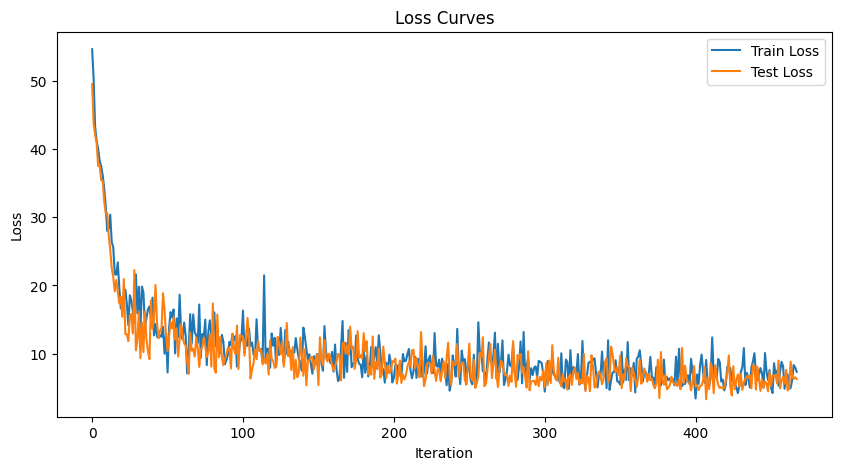

In [21]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

loss 곡선은 여러 반복에 걸쳐 평균을 내는 것이 아니라 모든 iteration에서 loss를 추적하기 때문에 노이즈가 발생합니다.

## 8.2 Test Set Accuracy
이 함수는 모든 미니배치를 반복하여 테스트 세트의 전체 10,000개 샘플에 대한 정확도 측정값을 얻습니다.

In [22]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9420/10000
Test Set Accuracy: 94.20%


짜잔! SNN기반 static MNIST 훈련은 여기까지입니다. 네트워크 매개변수, 하이퍼파라미터, decay rate, learning rate, scheduler 등을 자유롭게 조정하여 네트워크의 성능을 개선할 수 있는지 확인해 보세요.

# Conclusion
이제 정적 데이터 세트에서 fully-connected 네트워크를 구축하고 훈련하는 방법을 배웠습니다. 스파이킹 뉴런은 컨볼루션과 skip-connection을 포함한 다른 레이어 유형에도 적용할 수 있습니다. 이 지식으로 무장했다면 이제 다양한 유형의 SNN을 구축할 수 있을 겁니다. [다음 튜토리얼](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서는, 스파이킹 컨볼루션 네트워크를 훈련하는 방법과 `snn.backprop` 모듈을 사용하여 필요한 코드의 양을 간소화하는 방법을 배워보겠습니다.

또한 튜토리얼에 대한 귀중한 피드백을 제공해 주신 Bugra Kaytanli에게 특별히 감사드립니다.

이 프로젝트가 마음에 드신다면 GitHub에서 리포지토리의 ⭐(Star)를 눌러주세요.

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)